<a href="https://colab.research.google.com/github/jessicanadalete/clustering_fidelity/blob/main/Clustering_Fidelity_Project_Cycle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.0 Import Libraries
-----

In [64]:
pip install inflection

In [65]:
pip install umap-learn

In [66]:
import inflection
import datetime
import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap

from sklearn              import cluster        as c
from sklearn              import metrics        as m
from yellowbrick.cluster  import KElbowVisualizer
from yellowbrick.cluster  import SilhouetteVisualizer
from matplotlib           import pyplot         as plt
from plotly               import express        as px

### 0.1 Load Dataset

In [67]:
data_raw = pd.read_csv('/content/Ecommerce.csv', encoding='unicode_escape')

## 1.0 Data Description

---






In [68]:
df1 = data_raw.copy()

###1.1 Data Dimension

In [69]:
df1.shape

(541909, 9)

In [70]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [71]:
df1 = df1.drop('Unnamed: 8', axis=1)

In [72]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### 1.2 Rename Columns

In [73]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [74]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

In [75]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.3 Data Types

In [76]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,float64
customer_id,float64
country,object


### 1.4 Check NAs

In [77]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,1454
quantity,0
invoice_date,0
unit_price,0
customer_id,135080
country,0


### 1.5 Remove/Replace NAs

In [78]:
df1 = df1.dropna(subset=['description','customer_id'])

In [79]:
df1.shape

(406829, 8)

In [80]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


###1.6 Change Types

In [81]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

In [82]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [83]:
df1['unit_price'] = df1['unit_price'].astype(float)

In [84]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,datetime64[ns]
unit_price,float64
customer_id,int64
country,object


###1.7 Statistic Description

## 2.0 Feature Engineering
-----

In [85]:
df2 = df1.copy()

In [86]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [87]:
df2.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

###2.1 Feature Creation

In [88]:
#data reference - creating a dataframe with unique values
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True) #extrating customer_ids and reseting index
df_ref.shape

(4372, 1)

In [89]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [90]:
# creating Gross Revenue variable (Faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# creating Monetary (value spent by customer)
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

# creating Recency variable (last date purchase)
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index() # getting the last date purchase by customer
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days # calculating and extrating days quantity
df_recency = df_recency[['customer_id','recency_days']].copy() #selecting columns

# creating Frquency (purchase quantities)
df_frequency = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

In [91]:
#creating avg ticket (value average by custumer)
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_avg_ticket.head()

,customer_id,avg_ticket
0,12346,0.000000
1,12347,23.681319
2,12348,57.975484
3,12349,24.076027
4,12350,19.670588


In [92]:
df2['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [93]:
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [94]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


In [95]:
df_ref.isna().sum()

,0
customer_id,0
gross_revenue,0
recency_days,0
invoice_no,0
avg_ticket,0


## 3.0 Data Filtering
-----

In [96]:
df3 = df_ref.copy()

## 4.0 EDA (Exploratory Data Analysis)
-----

In [97]:
df4 = df3.copy()

## 5.0 Data Preparation
-----

In [98]:
df5 = df4.copy()

## 6.0 Feature Selection
-----

In [99]:
df6 = df5.copy()

## 7.0 Hyperparameter Fine-Tunning
-----

In [100]:
df7 = df6.copy()

In [101]:
X = df7.drop(columns = ['customer_id']) #droping variable without information

In [102]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


In [103]:
clusters = [2,3,4,5,6,7]

###7.1 Within-Cluster Sum of Square (WSS)

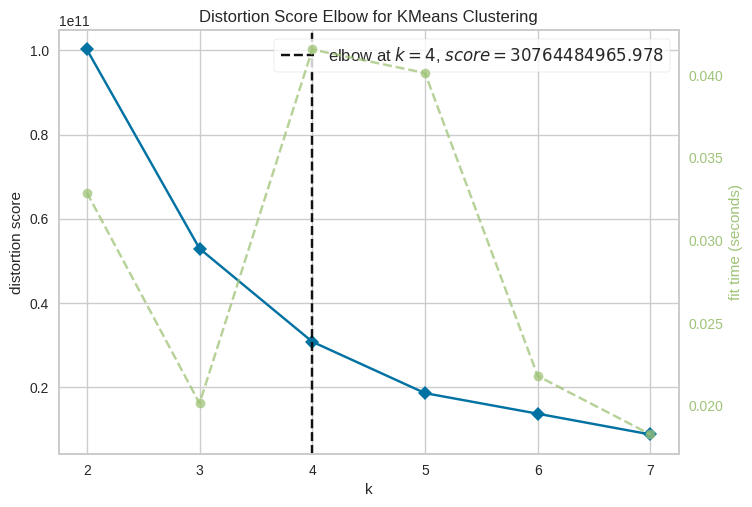

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:
#model defining and analyzing Elbow
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show()

###7.2 Silhouette Score

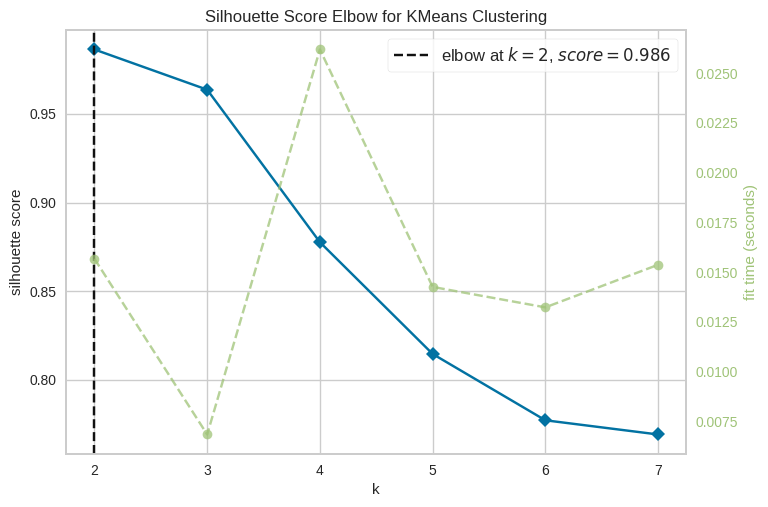

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [105]:
#model defining and analyzing Elbow
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show()

##7.3 Silhouette Analysis

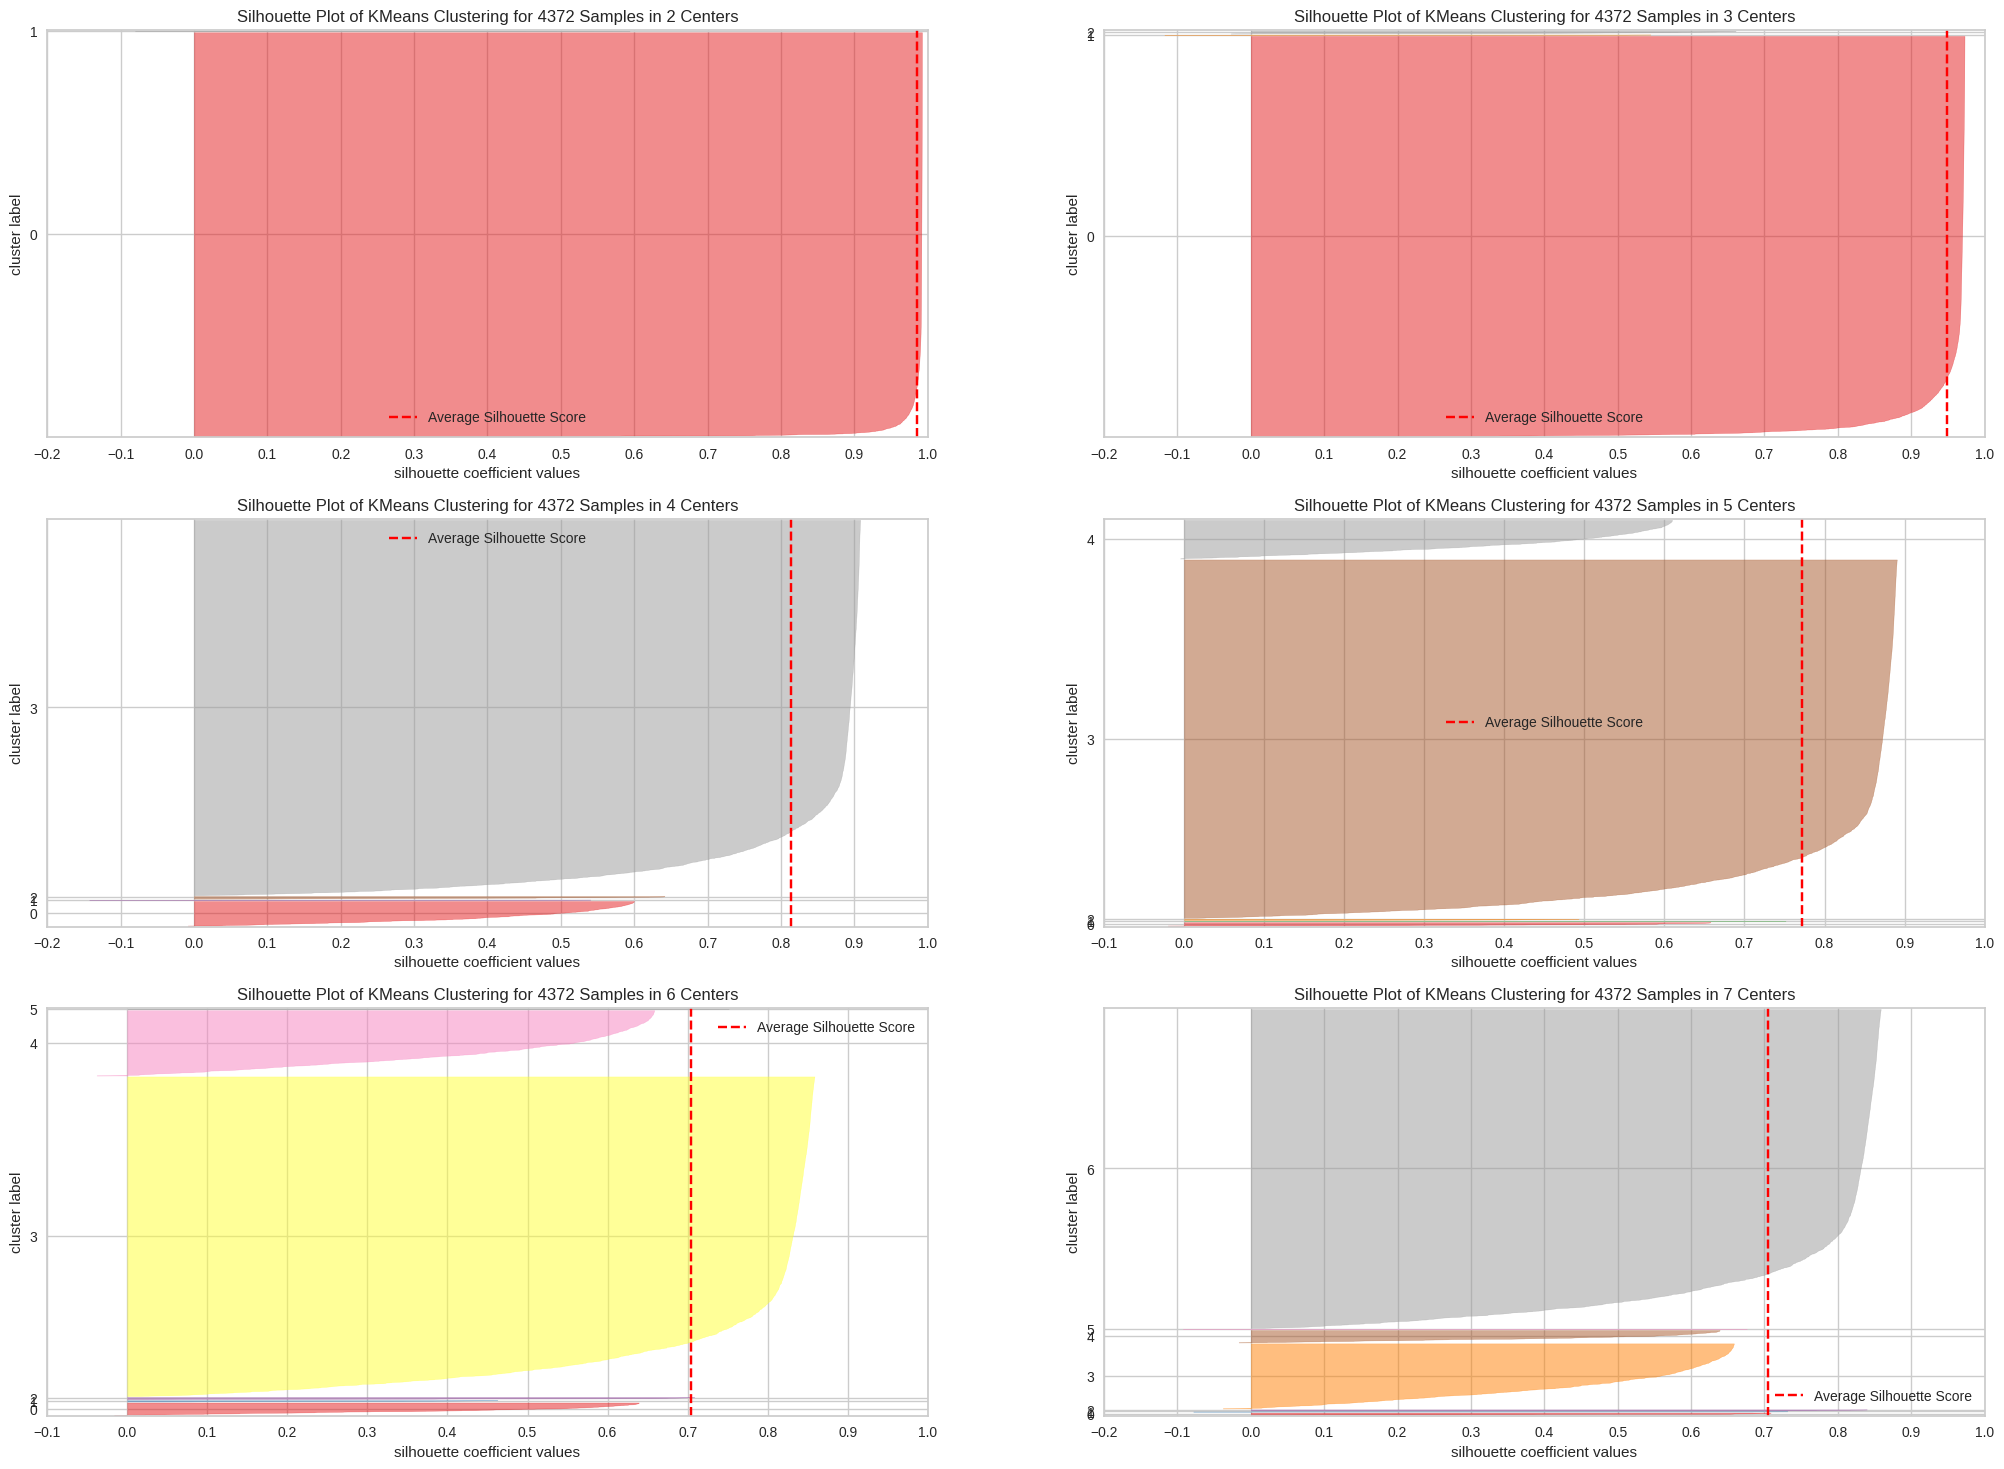

In [106]:
fig, axes = plt.subplots(3, 2, figsize=(25, 18))

# transform 2d matrix to a list
axes = axes.flatten()

for i, k in enumerate(clusters):
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=axes[i])
    visualizer.fit(X)
    visualizer.finalize()

In [107]:
# fig, ax = plt.subplots (3,2,figsize=(25,18))
# for k in clusters:
#   km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
#   q, mod = divmod(k,2)
#   visualizer = SilhouetteVisualizer(km, color='yellowbricks', ax=ax[q-1][mod])
#   visualizer.fit(X)
#   visualizer.finalize()

## 8.0 Model Training
-----

###8.1 K-means Model

In [108]:
# model definition
k = 4
kmeans = c.KMeans (init='random', n_clusters=k,n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

###8.2 Cluster Validation

In [109]:
# WSS
print('WSS value {}'.format(kmeans.inertia_))

#Silhouette Score
print('Silhouette Score {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value 40056506734.60232
Silhouette Score 0.8139972028952444


## 9.0 Cluster Analysis
-----

In [110]:
df9 = df7.copy()

In [111]:
df9['cluster'] = labels

###9.1 Visualization Inspection

In [112]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

### 2D Plot

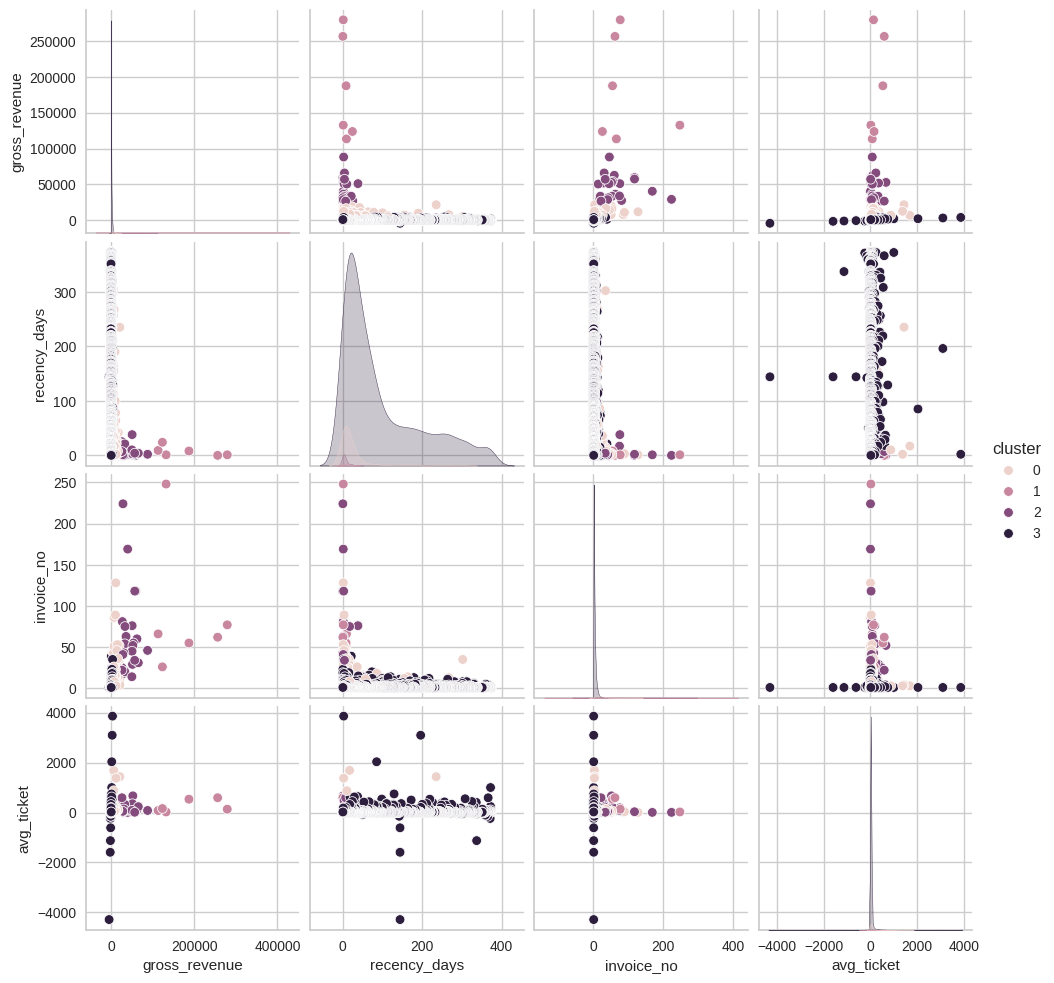

In [113]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### UMAP - t-SNE (Manifold - Learning by topology)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='embedding_x', ylabel='embedding_y'>

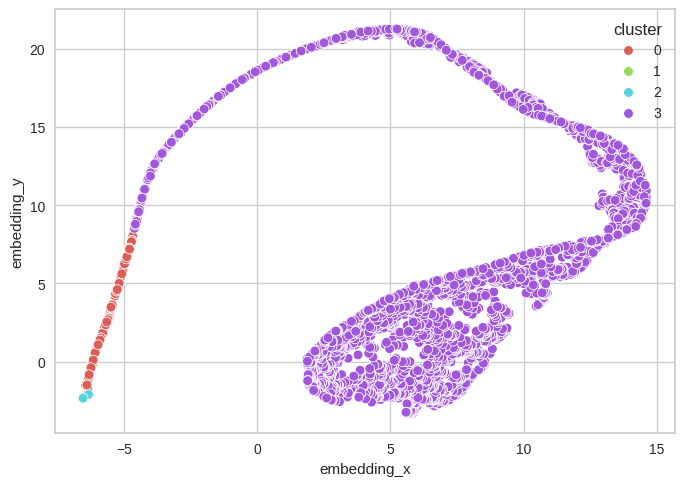

In [114]:
reducer = umap.UMAP(n_neighbors=50, random_state=42)
embedding = reducer.fit_transform(X) #projecting space

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster',
                palette=sns.color_palette('hls', n_colors=df_viz['cluster'].nunique()),
                data=df_viz)

###9.2 Cluster Profile

In [116]:
#Number of customer by cluster
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['percentage'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())
df_cluster

,cluster,customer_id,percentage
0,0,267,6.107045
1,1,6,0.137237
2,2,28,0.640439
3,3,4071,93.115279


In [117]:
# Gross Revenue Average
df_gr_avg = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gr_avg, how='inner', on='cluster')
df_cluster

,cluster,customer_id,percentage,gross_revenue
0,0,267,6.107045,8089.028652
1,1,6,0.137237,182181.981667
2,2,28,0.640439,42614.387143
3,3,4071,93.115279,946.696250


In [118]:
# Recency Days Average
df_gr_avg = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gr_avg, how='inner', on='cluster')
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency_days
0,0,267,6.107045,8089.028652,20.280899
1,1,6,0.137237,182181.981667,7.166667
2,2,28,0.640439,42614.387143,6.178571
3,3,4071,93.115279,946.696250,96.969295


In [119]:
# Invoice_no Average
df_gr_avg = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gr_avg, how='inner', on='cluster')
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency_days,invoice_no
0,0,267,6.107045,8089.028652,20.280899,19.528090
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,28,0.640439,42614.387143,6.178571,57.821429
3,3,4071,93.115279,946.696250,96.969295,3.641120


In [120]:
#Ticket Average
ticket_avg = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, ticket_avg, how='inner', on='cluster')
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,267,6.107045,8089.028652,20.280899,19.528090,62.783157
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,4071,93.115279,946.696250,96.969295,3.641120,25.359654


##Report
### Cluster 1 (Potential Insider):
- Customers: 6 (0.14% of total customer)
- Recency Average: 7 days
- Purchase Average: 89 purchases
- Gross Revenue Average: $182,182.00

### Cluster 2:
- Customers: 13 (0.7% of total customer)
- Recency Average: 14 days
- Purchase Average: 53 purchases
- Gross Revenue Average: $40,543.50

### Cluster 3:
- Customers: 4335 (99% of total customer)
- Recency Average: 92 days
- Purchase Average: 5 purchases
- Gross Revenue Average: $1,372.50


## 10.0 Deploy to Production
-----